<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v2.0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [74]:
## section: Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [75]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA A100-SXM4-40GB
Memory Usage:
Allocated: 0.6 GB
Cached:    0.8 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


## Step01: Data exploration

In [76]:
## Download from cifar10
dataset = 'cifar10' # change this one
torch.manual_seed(1311)
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip()
    ])
)

testing_data = datasets.CIFAR10(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [77]:
num_class = len(training_data.classes)
num_class

10

### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 4
Preview Images with Label : truck
Show of images unique labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


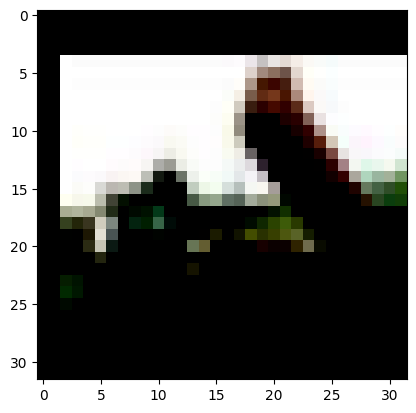

In [78]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
print("Show of images unique labels: ",classes)

### Tranforms to Dataloader

In [106]:
batch_size = 32
## apply the dataloader
torch.manual_seed(1311)
trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory = True
    )

testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory = True
    )

### Review the Batch fig and size

torch.Size([16, 3, 32, 32])


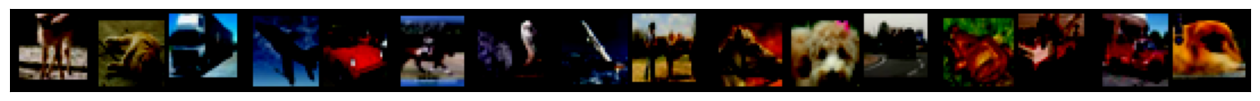

In [80]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [97]:
## adding the progress bar
import time
from tqdm import tqdm
import gc

def reset_memory():
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def train_network(model, optimizer, criterion, trainloader, testloader, num_epochs, seed=1311, num_class = num_class):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    set_seed(seed)  # Set the seed
    print('Using device:', device,"with seed: ",seed)
    print()

    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    # create set to collect the output
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # get the input and output
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward feed
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        scheduler.step()

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train.double() / total_train
        train_loss.append(epoch_loss)
        train_accuracy.append(int(100 * epoch_acc))

        # Validation
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs} Testing'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)



                if epoch + 1 == num_epochs:
                  # class_correct = list(0. for i in range(num_class))
                  # class_total = list(0. for i in range(num_class))
                  c = (preds == labels).squeeze()
                  for i in range(labels.size(0)):
                      label = labels[i]
                      class_correct[label] += c[i].item()
                      class_total[label] += 1



        epoch_test_loss = running_test_loss / total_test
        test_loss.append(epoch_test_loss)
        test_accuracy.append(int(100 * correct_test.double() / total_test))

        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {100 * epoch_acc:.2f}%, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {100 * correct_test.double() / total_test:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

        if epoch + 1 == num_epochs:
          print('Accuracy for each class')
          for i in range(num_class):
            # print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            if class_total[i] > 0:
                print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            else:
                print('Accuracy of %5s : N/A (no training examples)' % (classes[i]))

    reset_memory()

    return train_loss, train_accuracy, test_loss, test_accuracy

## Initialize network

### network: workshop CNN

In [82]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes=num_class):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        if num_class == 10:
          self.fc1 = nn.Linear(16 * 5 * 5, 120)
          self.fc2 = nn.Linear(120, 84)
          self.fc3 = nn.Linear(84, num_class)
        else:
          self.fc1 = nn.Linear(16 * 5 * 5, 200)
          self.fc2 = nn.Linear(200, 120)
          self.fc3 = nn.Linear(120, num_class)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### network: SimpleCNN

In [83]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_class):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### network: Alexnet

In [84]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [85]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [86]:
def plot_loss(train_loss, val_loss):
    """ Plot the history of losses"""
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show();




def plot_acc(train_acc, val_acc):
    """ Plot the accuracies in each epoch"""
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show();

results = []

In [111]:
# set the whole network training
import torch.optim as optim
num_epochs = 15
criterion = nn.CrossEntropyLoss()

### Train the network - net

In [102]:
# # individual configuration
# net = Net().to(device)
# model = net
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# # training model
# net_results = train_network(model,
#                             optimizer,
#                             criterion,
#                             trainloader,
#                             testloader,
#                             num_epochs
#                             )

# # plot the chart
# plot_loss(net_results[0], net_results[2])
# plot_acc(net_results[1], net_results[3])

# # save the model info
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)


### Train the network - simpleCNN

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 111.32it/s]


Epoch 1/15, Train Loss: 1.5566, Train Acc: 42.57%, Test Loss: 1.2178, Test Acc: 56.17%, Time: 27.74s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.76it/s]


Epoch 2/15, Train Loss: 1.2021, Train Acc: 56.77%, Test Loss: 0.9971, Test Acc: 64.56%, Time: 27.73s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.87it/s]


Epoch 3/15, Train Loss: 1.0173, Train Acc: 63.69%, Test Loss: 0.8957, Test Acc: 69.02%, Time: 27.83s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.60it/s]


Epoch 4/15, Train Loss: 0.9074, Train Acc: 67.84%, Test Loss: 0.8201, Test Acc: 71.18%, Time: 27.60s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.85it/s]


Epoch 5/15, Train Loss: 0.8272, Train Acc: 70.93%, Test Loss: 0.7345, Test Acc: 74.89%, Time: 27.64s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.87it/s]


Epoch 6/15, Train Loss: 0.7650, Train Acc: 73.13%, Test Loss: 0.6880, Test Acc: 76.16%, Time: 27.61s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.59it/s]


Epoch 7/15, Train Loss: 0.7194, Train Acc: 74.81%, Test Loss: 0.6787, Test Acc: 76.77%, Time: 27.60s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.87it/s]


Epoch 8/15, Train Loss: 0.6719, Train Acc: 76.44%, Test Loss: 0.6700, Test Acc: 77.31%, Time: 27.56s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.54it/s]


Epoch 9/15, Train Loss: 0.6408, Train Acc: 77.53%, Test Loss: 0.6399, Test Acc: 78.06%, Time: 27.51s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.61it/s]


Epoch 10/15, Train Loss: 0.6116, Train Acc: 78.57%, Test Loss: 0.6034, Test Acc: 79.17%, Time: 27.61s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.37it/s]


Epoch 11/15, Train Loss: 0.5872, Train Acc: 79.38%, Test Loss: 0.6152, Test Acc: 79.15%, Time: 27.57s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.80it/s]


Epoch 12/15, Train Loss: 0.5673, Train Acc: 80.18%, Test Loss: 0.6425, Test Acc: 78.45%, Time: 27.64s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.83it/s]


Epoch 13/15, Train Loss: 0.5422, Train Acc: 81.15%, Test Loss: 0.6014, Test Acc: 79.67%, Time: 27.49s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 116.35it/s]


Epoch 14/15, Train Loss: 0.5186, Train Acc: 81.76%, Test Loss: 0.5777, Test Acc: 80.66%, Time: 27.50s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 88.39it/s]


Epoch 15/15, Train Loss: 0.5047, Train Acc: 82.35%, Test Loss: 0.5757, Test Acc: 80.64%, Time: 28.47s
Accuracy for each class
Accuracy of airplane : 75 %
Accuracy of automobile : 86 %
Accuracy of  bird : 73 %
Accuracy of   cat : 66 %
Accuracy of  deer : 82 %
Accuracy of   dog : 67 %
Accuracy of  frog : 89 %
Accuracy of horse : 83 %
Accuracy of  ship : 92 %
Accuracy of truck : 90 %


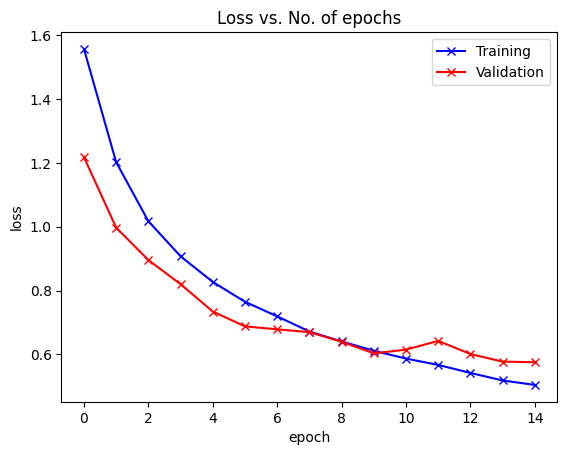

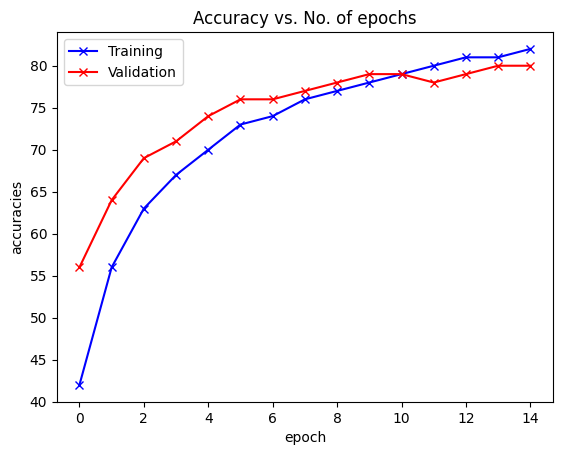

./cifar10_simplecnn.pth


In [113]:
# individual configuration
simplecnn = SimpleCNN().to(device)
model_name = "simplecnn"
model = simplecnn
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
simplecnn_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(simplecnn_results[0], simplecnn_results[2])
plot_acc(simplecnn_results[1], simplecnn_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(simplecnn.state_dict(), PATH)

### Train the network - Alexnet

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 107.23it/s]


Epoch 1/15, Train Loss: 1.6296, Train Acc: 38.55%, Test Loss: 1.2385, Test Acc: 54.77%, Time: 34.95s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 105.78it/s]


Epoch 2/15, Train Loss: 1.2261, Train Acc: 55.92%, Test Loss: 1.0420, Test Acc: 62.46%, Time: 34.85s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 105.03it/s]


Epoch 3/15, Train Loss: 1.0159, Train Acc: 64.28%, Test Loss: 0.9530, Test Acc: 66.60%, Time: 34.79s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 105.45it/s]


Epoch 4/15, Train Loss: 0.8866, Train Acc: 69.13%, Test Loss: 0.7818, Test Acc: 72.72%, Time: 35.27s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 104.38it/s]


Epoch 5/15, Train Loss: 0.7914, Train Acc: 72.51%, Test Loss: 0.7430, Test Acc: 74.47%, Time: 35.61s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.53it/s]


Epoch 6/15, Train Loss: 0.7277, Train Acc: 74.88%, Test Loss: 0.6632, Test Acc: 77.23%, Time: 35.19s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 107.89it/s]


Epoch 7/15, Train Loss: 0.6780, Train Acc: 76.77%, Test Loss: 0.6139, Test Acc: 78.71%, Time: 35.37s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 107.88it/s]


Epoch 8/15, Train Loss: 0.6296, Train Acc: 78.18%, Test Loss: 0.6199, Test Acc: 79.05%, Time: 35.26s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 109.00it/s]


Epoch 9/15, Train Loss: 0.6042, Train Acc: 79.24%, Test Loss: 0.6110, Test Acc: 79.71%, Time: 34.86s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 107.69it/s]


Epoch 10/15, Train Loss: 0.5698, Train Acc: 80.48%, Test Loss: 0.5963, Test Acc: 79.59%, Time: 34.92s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 108.52it/s]


Epoch 11/15, Train Loss: 0.5489, Train Acc: 81.20%, Test Loss: 0.5893, Test Acc: 80.70%, Time: 34.89s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 108.09it/s]


Epoch 12/15, Train Loss: 0.5280, Train Acc: 82.02%, Test Loss: 0.6327, Test Acc: 78.87%, Time: 34.70s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 109.07it/s]


Epoch 13/15, Train Loss: 0.5130, Train Acc: 82.62%, Test Loss: 0.5446, Test Acc: 81.93%, Time: 34.73s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.99it/s]


Epoch 14/15, Train Loss: 0.4919, Train Acc: 83.16%, Test Loss: 0.5522, Test Acc: 81.66%, Time: 34.88s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 84.60it/s]


Epoch 15/15, Train Loss: 0.4799, Train Acc: 83.62%, Test Loss: 0.5209, Test Acc: 83.37%, Time: 35.65s
Accuracy for each class
Accuracy of airplane : 85 %
Accuracy of automobile : 90 %
Accuracy of  bird : 76 %
Accuracy of   cat : 65 %
Accuracy of  deer : 87 %
Accuracy of   dog : 67 %
Accuracy of  frog : 90 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 89 %


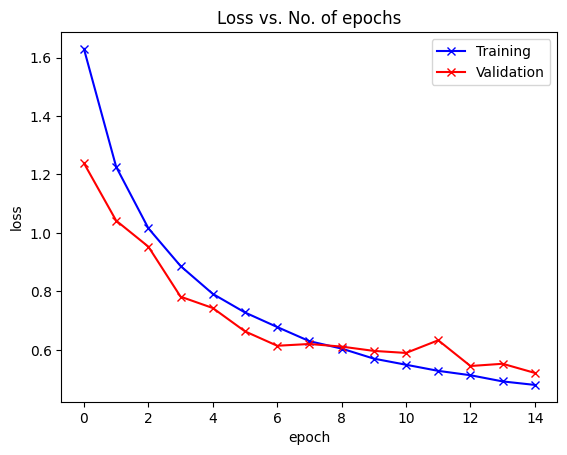

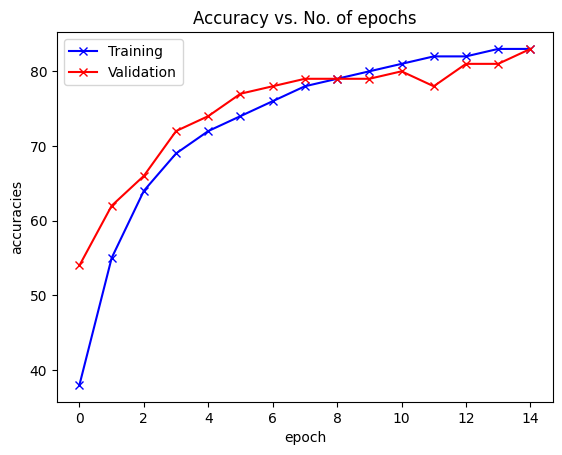

./cifar10_alexnet.pth


In [114]:
# individual configuration
alexnet = AlexNet().to(device)
model_name = "alexnet"
model = alexnet
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
alexnet_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(alexnet_results[0], alexnet_results[2])
plot_acc(alexnet_results[1], alexnet_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(alexnet.state_dict(), PATH)

### Train the network - Resnet18

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.22it/s]


Epoch 1/15, Train Loss: 1.3472, Train Acc: 50.98%, Test Loss: 1.0150, Test Acc: 64.22%, Time: 40.81s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.50it/s]


Epoch 2/15, Train Loss: 0.8642, Train Acc: 69.55%, Test Loss: 0.7330, Test Acc: 74.54%, Time: 40.50s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.79it/s]


Epoch 3/15, Train Loss: 0.6852, Train Acc: 76.29%, Test Loss: 0.6033, Test Acc: 79.19%, Time: 40.08s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.02it/s]


Epoch 4/15, Train Loss: 0.5839, Train Acc: 79.90%, Test Loss: 0.5036, Test Acc: 82.94%, Time: 40.06s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.24it/s]


Epoch 5/15, Train Loss: 0.5106, Train Acc: 82.45%, Test Loss: 0.5207, Test Acc: 82.28%, Time: 40.09s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.81it/s]


Epoch 6/15, Train Loss: 0.4543, Train Acc: 84.44%, Test Loss: 0.4426, Test Acc: 85.22%, Time: 39.91s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 93.60it/s]


Epoch 7/15, Train Loss: 0.4119, Train Acc: 85.75%, Test Loss: 0.4357, Test Acc: 85.51%, Time: 40.19s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.28it/s]


Epoch 8/15, Train Loss: 0.3736, Train Acc: 87.11%, Test Loss: 0.4139, Test Acc: 86.24%, Time: 40.34s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 93.04it/s]


Epoch 9/15, Train Loss: 0.3384, Train Acc: 88.23%, Test Loss: 0.3772, Test Acc: 87.06%, Time: 40.58s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.46it/s]


Epoch 10/15, Train Loss: 0.3130, Train Acc: 89.31%, Test Loss: 0.3706, Test Acc: 87.66%, Time: 40.63s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 93.12it/s]


Epoch 11/15, Train Loss: 0.2941, Train Acc: 89.76%, Test Loss: 0.4074, Test Acc: 86.73%, Time: 40.50s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.42it/s]


Epoch 12/15, Train Loss: 0.2707, Train Acc: 90.61%, Test Loss: 0.3288, Test Acc: 89.02%, Time: 40.16s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.66it/s]


Epoch 13/15, Train Loss: 0.2523, Train Acc: 91.17%, Test Loss: 0.3435, Test Acc: 88.49%, Time: 40.22s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 93.01it/s]


Epoch 14/15, Train Loss: 0.2314, Train Acc: 91.91%, Test Loss: 0.3107, Test Acc: 89.97%, Time: 40.09s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.10it/s]


Epoch 15/15, Train Loss: 0.2174, Train Acc: 92.48%, Test Loss: 0.3484, Test Acc: 89.31%, Time: 40.81s
Accuracy for each class
Accuracy of airplane : 90 %
Accuracy of automobile : 92 %
Accuracy of  bird : 79 %
Accuracy of   cat : 81 %
Accuracy of  deer : 88 %
Accuracy of   dog : 80 %
Accuracy of  frog : 96 %
Accuracy of horse : 92 %
Accuracy of  ship : 95 %
Accuracy of truck : 96 %


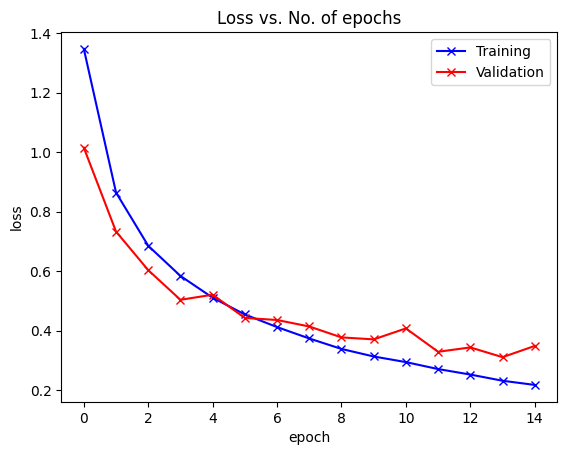

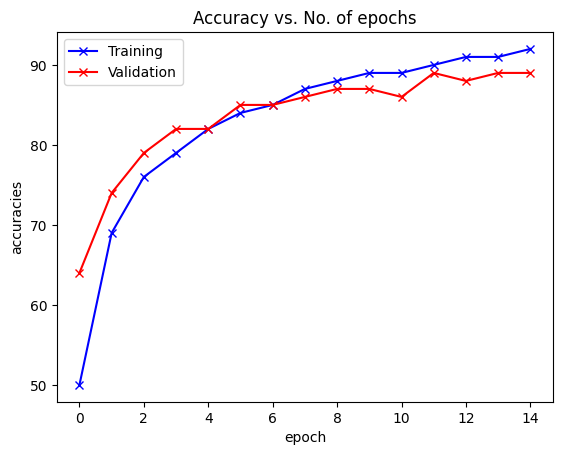

./cifar10_resnet18.pth


In [115]:
# individual configuration
resnet18 = ResNet18().to(device)
model_name = "resnet18"
model = resnet18
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet18_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet18_results[0], resnet18_results[2])
plot_acc(resnet18_results[1], resnet18_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet18.state_dict(), PATH)

### Train the network - Resnet34

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.49it/s]


Epoch 1/15, Train Loss: 1.5160, Train Acc: 44.35%, Test Loss: 1.1076, Test Acc: 59.77%, Time: 51.66s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 78.08it/s]


Epoch 2/15, Train Loss: 1.0284, Train Acc: 63.54%, Test Loss: 0.9513, Test Acc: 67.09%, Time: 51.74s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 78.11it/s]


Epoch 3/15, Train Loss: 0.7994, Train Acc: 71.87%, Test Loss: 0.7032, Test Acc: 75.56%, Time: 51.60s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.33it/s]


Epoch 4/15, Train Loss: 0.6581, Train Acc: 77.31%, Test Loss: 0.5645, Test Acc: 80.59%, Time: 51.46s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.35it/s]


Epoch 5/15, Train Loss: 0.5689, Train Acc: 80.18%, Test Loss: 0.5530, Test Acc: 81.22%, Time: 51.30s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.35it/s]


Epoch 6/15, Train Loss: 0.5023, Train Acc: 82.54%, Test Loss: 0.4969, Test Acc: 83.09%, Time: 51.67s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.72it/s]


Epoch 7/15, Train Loss: 0.4509, Train Acc: 84.48%, Test Loss: 0.4483, Test Acc: 84.87%, Time: 51.30s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.30it/s]


Epoch 8/15, Train Loss: 0.4074, Train Acc: 85.90%, Test Loss: 0.4699, Test Acc: 84.55%, Time: 51.41s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 79.45it/s]


Epoch 9/15, Train Loss: 0.3666, Train Acc: 87.31%, Test Loss: 0.4067, Test Acc: 86.21%, Time: 51.69s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.17it/s]


Epoch 10/15, Train Loss: 0.3383, Train Acc: 88.41%, Test Loss: 0.3907, Test Acc: 86.93%, Time: 51.47s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 77.14it/s]


Epoch 11/15, Train Loss: 0.3175, Train Acc: 88.95%, Test Loss: 0.4005, Test Acc: 86.85%, Time: 51.74s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 78.49it/s]


Epoch 12/15, Train Loss: 0.2928, Train Acc: 89.95%, Test Loss: 0.3559, Test Acc: 88.29%, Time: 51.72s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:03<00:00, 79.04it/s]


Epoch 13/15, Train Loss: 0.2715, Train Acc: 90.57%, Test Loss: 0.3527, Test Acc: 88.91%, Time: 51.58s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 78.24it/s]


Epoch 14/15, Train Loss: 0.2485, Train Acc: 91.29%, Test Loss: 0.3115, Test Acc: 89.70%, Time: 51.61s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.91it/s]


Epoch 15/15, Train Loss: 0.2340, Train Acc: 91.95%, Test Loss: 0.3128, Test Acc: 89.82%, Time: 52.17s
Accuracy for each class
Accuracy of airplane : 88 %
Accuracy of automobile : 95 %
Accuracy of  bird : 83 %
Accuracy of   cat : 81 %
Accuracy of  deer : 91 %
Accuracy of   dog : 81 %
Accuracy of  frog : 94 %
Accuracy of horse : 92 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %


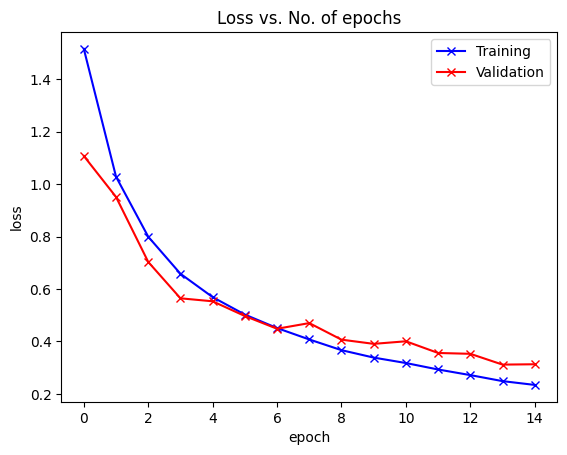

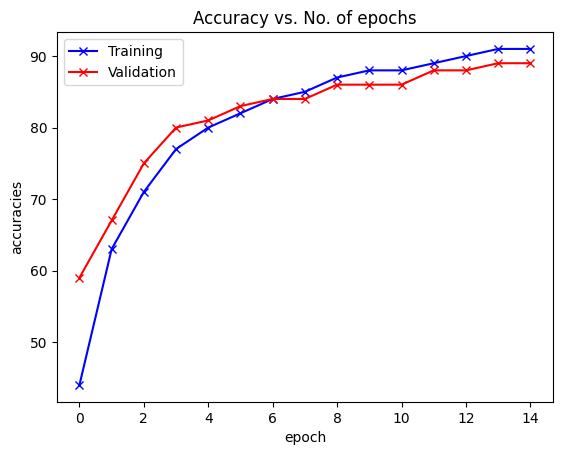

./cifar10_resnet34.pth


In [116]:
# individual configuration
resnet34 = ResNet34().to(device)
model_name = "resnet34"
model = resnet34
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet34_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet34_results[0], resnet34_results[2])
plot_acc(resnet34_results[1], resnet34_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet34.state_dict(), PATH)

### Train the network - Resnet50

Using device: cuda with seed:  1311



Epoch 1/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 67.09it/s]


Epoch 1/15, Train Loss: 1.4975, Train Acc: 45.73%, Test Loss: 1.0993, Test Acc: 60.89%, Time: 62.41s


Epoch 2/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.79it/s]


Epoch 2/15, Train Loss: 0.9984, Train Acc: 64.73%, Test Loss: 1.1599, Test Acc: 63.13%, Time: 62.76s


Epoch 3/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.83it/s]


Epoch 3/15, Train Loss: 0.8039, Train Acc: 71.97%, Test Loss: 0.8211, Test Acc: 72.63%, Time: 62.78s


Epoch 4/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.48it/s]


Epoch 4/15, Train Loss: 0.6867, Train Acc: 76.23%, Test Loss: 0.6022, Test Acc: 78.82%, Time: 62.74s


Epoch 5/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.08it/s]


Epoch 5/15, Train Loss: 0.5967, Train Acc: 79.47%, Test Loss: 0.6145, Test Acc: 78.45%, Time: 62.81s


Epoch 6/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 67.74it/s]


Epoch 6/15, Train Loss: 0.5402, Train Acc: 81.45%, Test Loss: 0.5164, Test Acc: 82.54%, Time: 62.14s


Epoch 7/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.95it/s]


Epoch 7/15, Train Loss: 0.4894, Train Acc: 83.22%, Test Loss: 0.5136, Test Acc: 82.89%, Time: 62.64s


Epoch 8/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 67.23it/s]


Epoch 8/15, Train Loss: 0.4516, Train Acc: 84.48%, Test Loss: 0.4707, Test Acc: 83.82%, Time: 62.26s


Epoch 9/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.14it/s]


Epoch 9/15, Train Loss: 0.4083, Train Acc: 86.05%, Test Loss: 0.4466, Test Acc: 85.16%, Time: 62.77s


Epoch 10/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 67.58it/s]


Epoch 10/15, Train Loss: 0.3865, Train Acc: 86.64%, Test Loss: 0.4186, Test Acc: 86.44%, Time: 62.63s


Epoch 11/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.58it/s]


Epoch 11/15, Train Loss: 0.3637, Train Acc: 87.40%, Test Loss: 0.4241, Test Acc: 86.02%, Time: 62.83s


Epoch 12/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.85it/s]


Epoch 12/15, Train Loss: 0.3335, Train Acc: 88.54%, Test Loss: 0.3706, Test Acc: 87.67%, Time: 62.70s


Epoch 13/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 66.85it/s]


Epoch 13/15, Train Loss: 0.3100, Train Acc: 89.25%, Test Loss: 0.3773, Test Acc: 87.97%, Time: 62.41s


Epoch 14/15 Testing: 100%|██████████| 313/313 [00:04<00:00, 65.21it/s]


Epoch 14/15, Train Loss: 0.2921, Train Acc: 89.91%, Test Loss: 0.3440, Test Acc: 88.92%, Time: 63.06s


Epoch 15/15 Testing: 100%|██████████| 313/313 [00:05<00:00, 56.84it/s]


Epoch 15/15, Train Loss: 0.2784, Train Acc: 90.34%, Test Loss: 0.3434, Test Acc: 88.81%, Time: 64.53s
Accuracy for each class
Accuracy of airplane : 90 %
Accuracy of automobile : 88 %
Accuracy of  bird : 86 %
Accuracy of   cat : 77 %
Accuracy of  deer : 91 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 93 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %


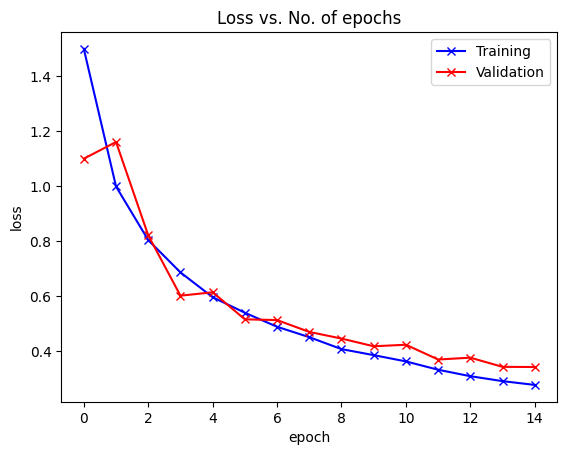

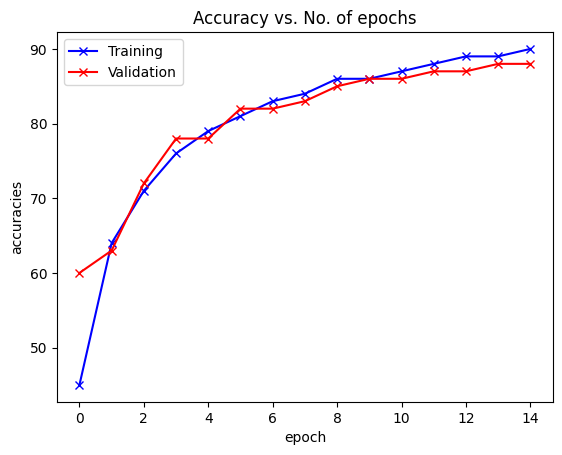

./cifar10_resnet50.pth


In [117]:
# individual configuration
resnet50 = ResNet50().to(device)
model_name = "resnet50"
model = resnet50
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=8e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs)

# training model
resnet50_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet50_results[0], resnet50_results[2])
plot_acc(resnet50_results[1], resnet50_results[3])

# save the model info
PATH = f'./{dataset}_{str(model_name)}.pth'
print(PATH)
torch.save(resnet50.state_dict(), PATH)

## Load the Model

In [165]:
# net = Net()
# net.load_state_dict(torch.load('./cifar_net.pth'))

simplecnn = SimpleCNN()
simplecnn.load_state_dict(torch.load(f'./{dataset}_simplecnn.pth'))

alexnet = AlexNet()
alexnet.load_state_dict(torch.load(f'./{dataset}_alexnet.pth'))

resnet18 = ResNet18()
resnet18.load_state_dict(torch.load(f'./{dataset}_resnet18.pth'))

resnet34 = ResNet34()
resnet34.load_state_dict(torch.load(f'./{dataset}_resnet34.pth'))

resnet50 = ResNet50()
resnet50.load_state_dict(torch.load(f'./{dataset}_resnet50.pth', map_location=device))

<All keys matched successfully>